<a href="https://colab.research.google.com/github/henryjchang/dl-notebooks/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Hands On with ML: Achieving >99% classifcation accuracy on MNIST




One of the most commonly used datasets in ML research has been the MNIST dataset. It's a small dataset containing 60,000 28x28 greyscale images of handwritten digits and their labels, with 10 distinct classes for the digits from 0-9. It's often used as a "Hello World" example for machine learning. In this notebook, we'll use it as such.

We go from doing some exploratory data analysis, through fully-connected models, up to training our first CNN model and achieving >99% classification accuracy on the dataset. Along the way, we write our own Learner class from scratch and use it to group together model, loss, optimizer, training and validation datasets.

This work was inspired by [this notebook](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) from the Fast.ai course, Practical Deep Learning for Coders.

### Import torchvision MNIST

We download the MNIST dataset from torchvision. As part of the download, we can specify any transformations to make to the data inputs or to the data labels. Here, we only transform the data inputs. To be able to properly do machine learning with images, we need to turn them from PIL images to PyTorch Tensors. We download two copies of the dataset, one with 2D tensors, and one with each image flattened into 1D tensors. We also leave the test set alone and split a validation set out of the training set for evaluation during training.

In [1]:
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader
import torch

train_dataset = MNIST(root='mnist', train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(root='mnist', train=False, download=True, transform=T.ToTensor())

train_dataset_flattened = MNIST(root='mnist/flattened/', train=True, download=True,
    transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]))
test_dataset_flattened = MNIST(root='mnist/flattened/', train=False, download=True,
    transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]))

100%|██████████| 9912422/9912422 [00:00<00:00, 109757814.24it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3492753.99it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58299471.42it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13183756.93it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 205380107.22it/s]

Extracting mnist/flattened/MNIST/raw/train-images-idx3-ubyte.gz to mnist/flattened/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 66558073.53it/s]


Extracting mnist/flattened/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/flattened/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 114943016.16it/s]

Extracting mnist/flattened/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/flattened/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13549451.47it/s]

Extracting mnist/flattened/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/flattened/MNIST/raw



### A first look at the data

In [ ]:
len(train_dataset)

60000

In [ ]:
len(test_dataset)

10000

Each image is a 3D tensor with a single channel (first dimension) and height and width of 28.

In [ ]:
i = 0
train_dataset[i][0].shape

torch.Size([1, 28, 28])

We can get the label of the *i*th image of the training dataset like so:

In [ ]:
train_dataset[i][1]

5

Similarly, we can get the label of the *i*th image of the test dataset:

In [ ]:
test_dataset[i][1]

7

In our flattened version of the dataset, each image has been flattened to be a 1D tensor.

In [ ]:
train_dataset_flattened[i][0].shape

torch.Size([784])

Let's take a look at the pixel values of the first training example. It's good practice to normalize input data to make the optimization landscape smoother so that it takes fewer iterations to converge to a good minimum. Notice all the values have already been normalized to be between 0 and 1, with 1 corresponding with "black" and 0 with "white."

In [ ]:
import pandas as pd

df = pd.DataFrame(torch.squeeze(train_dataset[0][0]))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys').format(precision=2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Lets see how many examples of each digit the training set contains.

In [3]:
digit_indices = {y: [] for y in range(10)}
[digit_indices[y].append(i) for i, (x, y) in enumerate(train_dataset)]

for i in range(10):
  print(i, 'has', len(digit_indices[i]), 'samples')

0 has 5923 samples
1 has 6742 samples
2 has 5958 samples
3 has 6131 samples
4 has 5842 samples
5 has 5421 samples
6 has 5918 samples
7 has 6265 samples
8 has 5851 samples
9 has 5949 samples


Lets see an example of each digit.

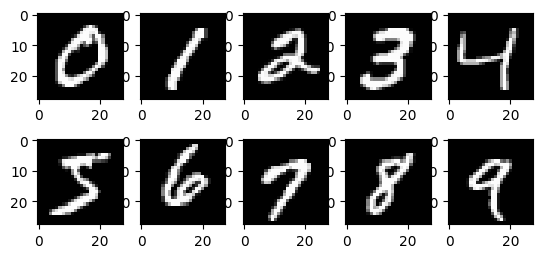

In [4]:
import matplotlib.pyplot as plt

for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(torch.squeeze(train_dataset[digit_indices[i][0]][0]), cmap=plt.get_cmap('gray'))
plt.subplots_adjust(bottom=0.4)
plt.show()

### Create a validation dataset

In [ ]:
import numpy as np

validation_frac = 0.2
num_samples = len(train_dataset)
split_idx = int(np.floor((1 - validation_frac) * num_samples))
train_idx = np.arange(split_idx)
valid_idx = np.arange(split_idx, num_samples)

In [ ]:
train_data = Subset(train_dataset, train_idx)
valid_data = Subset(train_dataset, valid_idx)

train_data_flat = Subset(train_dataset_flattened, train_idx)
valid_data_flat = Subset(train_dataset_flattened, valid_idx)

### Load Datasets into DataLoaders

`torch.utils.data.Dataset` and `torch.util.data.DataLoader` are the two primitives used in PyTorch to decouple pre-loaded data and data for model training.

Datasets, as we saw above, store inputs and their labels, and its elements can be accessed like with a Python dictionary.

DataLoaders, on the other hand, are more useful when training a model.

> "We typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.
>
> DataLoader is an iterable that abstracts this complexity for us in an easy API."

Source: [PyTorch data tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

One aspect of DataLoaders to keep in mind is the batch size parameter. Batch size can be dependent on dataset and architecture, both in terms of training stability and in terms of memory capacity. A larger batch size results in more stable training since the variance in gradient estimation per batch is reduced. However a larger batch size can cause the GPU to run out of memory.

We start experimenting with a batch size that is the length of the entire dataset and update it below for different approaches as needed. Note for our first baseline that no gradients are computed so batch size has no influence on "convergence speed."

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

### Pixel Similarity baseline model

Our first model takes a non-ML approach in favor of a straightforward elementwise pixel to pixel comparison per image. We compare a sample image to a mean image for each digit. The mean image is computed by averaging over the training examples per digit.

##### Calculate mean image per digit

In [ ]:
train_data_by_digit = {}
valid_data_by_digit = {}

for i in range(10):
  train_data_by_digit[i] = \
    torch.stack([sample[0] for sample in Subset(train_dataset, list(filter(lambda x: x < split_idx, digit_indices[i])))])
  valid_data_by_digit[i] = \
    torch.stack([sample[0] for sample in Subset(train_dataset, list(filter(lambda x: x >= split_idx, digit_indices[i])))])

In [ ]:
digit_means = {y: torch.Tensor() for y in range(10)}
for i in range(10):
  digit_means[i] = train_data_by_digit[i].mean(axis=0)

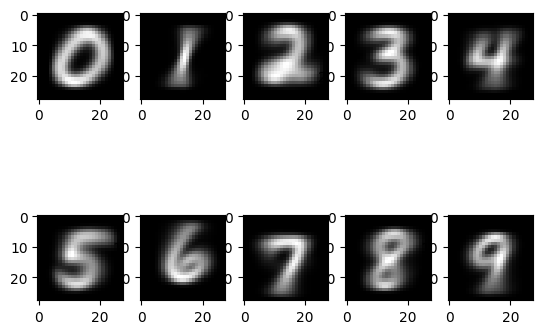

In [ ]:
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(torch.squeeze(digit_means[i]), cmap=plt.get_cmap('gray'))
plt.show()

##### Make predictions

In [ ]:
import torch.nn.functional as F

def predict(sample):
  # choose the digit whose mean image is closest to the sample
  return torch.argmin(torch.tensor([F.l1_loss(sample, torch.squeeze(digit_means[i])) for i in range(10)]))

def predict_batch(samples):
  return torch.tensor([predict(torch.squeeze(sample)) for sample in samples])

In [ ]:
preds = torch.empty(0)
labels = torch.empty(0)
for batch in test_dataloader:
  images, ls = batch
  preds = torch.cat((preds, predict_batch(images)), dim = 0)
  labels = torch.cat((labels, ls), dim = 0)

##### Get prediction accuracy and confusion matrix

In [ ]:
accuracy = torch.sum(torch.eq(labels, preds)) / len(labels)
print(accuracy)

tensor(0.667)


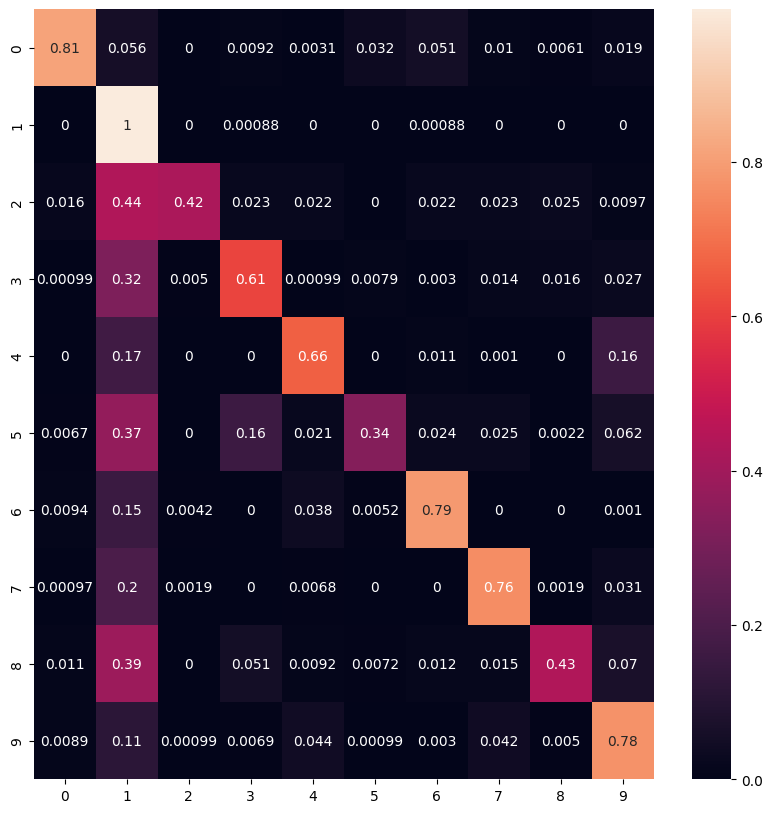

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(10)],
                     columns = [i for i in range(10)])

plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.show()

I'm surprised by how good this baseline already is, without any ML (>60% classification accuracy), but we can definitely do better.

### Learner class from scratch

There is a 7 step process for iterating on model weights:

1.   Initialize params
2.   Calculate predictions
3. Calculate the loss
4. Calculate the gradients
5. Step the parameters
6. Repeat the process
7. Stop

Lets implement a class that does this.

In [ ]:
class Learner:
  def __init__(self, dataloaders, model, optimizer, loss_func, metric, scheduler=None):
    self.dataloaders = dataloaders
    self.model = model
    self.optimizer = optimizer
    self.loss_func = loss_func
    self.metric = metric
    self.scheduler = scheduler
    self.val_losses = []

  def fit(self, epochs):
    for epoch in range(epochs):
      print("---- epoch: ", epoch, "/", epochs - 1, " ----")

      self.model.train()
      train_loss = 0.
      for (train_features, train_labels) in self.dataloaders.train_dl():
        preds = self.model(train_features)
        loss = self.loss_func(preds, train_labels)
        train_loss += loss
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        if self.scheduler:
          self.scheduler.step()
      print("avg training loss: ", train_loss / len(self.dataloaders.train_dl()))

      self.model.eval()
      with torch.no_grad():
        # We evaluate on the entire validation dataset
        val_preds = []
        val_labels = []
        for (val_features, val_ls) in self.dataloaders.valid_dl():
          val_preds.append(self.model(val_features))
          val_labels.append(val_ls)
        val_preds = torch.squeeze(torch.stack(val_preds, dim=0))
        val_labels = torch.squeeze(torch.stack(val_labels, dim=0))
        val_loss = self.loss_func(val_preds, val_labels)
        print("validation loss: ", val_loss)
        print("metric: ", self.metric(val_preds, val_labels))

        # Early stopping
        self.val_losses.append(val_loss)
        if len(self.val_losses) > 2 and self.val_losses[-1] > self.val_losses[-2] and self.val_losses[-2] > self.val_losses[-3]:
          print("stopping condition met")
          break

We also create a class to group together training and validation datasets that our Learner needs.

In [ ]:
class DataLoaders:
  def __init__(self, train_dataloader, valid_dataloader):
    self.train_dataloader = train_dataloader
    self.valid_dataloader = valid_dataloader

  def train_dl(self):
    return self.train_dataloader

  def valid_dl(self):
    return self.valid_dataloader

### Train a linear model

Now that we have a Learner class, we can train a linear model for sanity checking and to get another baseline. We still need a few concrete components in order to train: an architecture, an optimizer, and a loss function. We also add in a metric to be more human-friendly.

Additionally, with a Linear model, we need to work with flattened data. We use the flattened dataset that was prepared above.

In [ ]:
bs = 64
lr = 1e-1

In [ ]:
train_dataloader = DataLoader(train_data_flat, batch_size=bs, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data_flat, batch_size=len(valid_data), shuffle=True)
test_dataloader = DataLoader(test_dataset_flattened, batch_size=len(test_dataset_flattened), shuffle=True)

dls = DataLoaders(train_dataloader, valid_dataloader)

In [ ]:
model = torch.nn.Linear(28*28,10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
def digit_accuracy(preds, labels):
  return (torch.argmax(preds, axis=1) == labels).float().mean()

In [ ]:
learner = Learner(dls, model, optimizer, loss_func, digit_accuracy)

In [ ]:
learner.fit(1)

---- epoch:  0 / 0  ----
avg training loss:  tensor(0.510, grad_fn=<DivBackward0>)
validation loss:  tensor(0.347)
metric:  tensor(0.907)


In [ ]:
test_feats, test_labels = next(iter(test_dataloader))
preds = model(test_feats)
print("test accuracy: ", digit_accuracy(preds, test_labels))

test accuracy:  tensor(0.907)


Cool, looks like our linear model has learned something about handwritten digits and has a big improvement over the pixel-wise comparison baseline. But a linear model can only learn so much; a nonlinear model has more wiggle room (pun-intended) to fit the data.

### Train a feed-forward model

In [ ]:
ffn_model = torch.nn.Sequential(torch.nn.Linear(28*28, 64),
                                torch.nn.ReLU(),
                                torch.nn.Linear(64, 10)
                               )

lr = 1e-1
ffn_optimizer = torch.optim.SGD(ffn_model.parameters(), lr=lr)

In [ ]:
learner = Learner(dls, ffn_model, ffn_optimizer, loss_func, digit_accuracy)
learner.fit(10)

---- epoch:  0 / 9  ----
avg training loss:  tensor(0.502, grad_fn=<DivBackward0>)
validation loss:  tensor(0.286)
metric:  tensor(0.915)
---- epoch:  1 / 9  ----
avg training loss:  tensor(0.263, grad_fn=<DivBackward0>)
validation loss:  tensor(0.217)
metric:  tensor(0.940)
---- epoch:  2 / 9  ----
avg training loss:  tensor(0.207, grad_fn=<DivBackward0>)
validation loss:  tensor(0.198)
metric:  tensor(0.943)
---- epoch:  3 / 9  ----
avg training loss:  tensor(0.172, grad_fn=<DivBackward0>)
validation loss:  tensor(0.161)
metric:  tensor(0.954)
---- epoch:  4 / 9  ----
avg training loss:  tensor(0.148, grad_fn=<DivBackward0>)
validation loss:  tensor(0.154)
metric:  tensor(0.955)
---- epoch:  5 / 9  ----
avg training loss:  tensor(0.129, grad_fn=<DivBackward0>)
validation loss:  tensor(0.143)
metric:  tensor(0.958)
---- epoch:  6 / 9  ----
avg training loss:  tensor(0.115, grad_fn=<DivBackward0>)
validation loss:  tensor(0.128)
metric:  tensor(0.962)
---- epoch:  7 / 9  ----
avg train

In [ ]:
test_feats, test_labels = next(iter(test_dataloader))
preds = ffn_model(test_feats)
print("test accuracy: ", digit_accuracy(preds, test_labels))

test accuracy:  tensor(0.969)


That's decent accuracy, but we can do better and use fewer parameters by taking advantage of the spatial structure of an image!

### Train a CNN

In [ ]:
from torch import nn

def conv(ni, nf, stride=2, ks=3):
  return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks // 2)

In [ ]:
simple_cnn_model = nn.Sequential(
        conv(1 ,8, ks=5),        #14x14
        nn.ReLU(),
        conv(8 ,16),             #7x7
        nn.ReLU(),
        conv(16,32),             #4x4
        nn.ReLU(),
        conv(32,64),             #2x2
        nn.ReLU(),
        conv(64,10),             #1x1
        nn.Flatten()
        )
simple_cnn_optimizer = torch.optim.SGD(simple_cnn_model.parameters(), lr=1e-2)

In [ ]:
bs = 128 # larger batch size means more stable training, but fewer opportunities to update parameters

# Use the unflattened data
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

dls = DataLoaders(train_dataloader, valid_dataloader)

In [ ]:
learner = Learner(dls, simple_cnn_model, simple_cnn_optimizer, torch.nn.CrossEntropyLoss(), digit_accuracy)
learner.fit(3)

---- epoch:  0 / 2  ----
avg training loss:  tensor(2.301, grad_fn=<DivBackward0>)
validation loss:  tensor(2.301)
metric:  tensor(0.106)
---- epoch:  1 / 2  ----
avg training loss:  tensor(2.299, grad_fn=<DivBackward0>)
validation loss:  tensor(2.299)
metric:  tensor(0.106)
---- epoch:  2 / 2  ----
avg training loss:  tensor(2.297, grad_fn=<DivBackward0>)
validation loss:  tensor(2.297)
metric:  tensor(0.106)


Uh oh...the model doesn't train very well...we're going to need a few tricks.

### Train a performant CNN to achieve high accuracy on MNIST

#### Learning rate scheduling: 1cycle training

1cycle LR training allows us to stably use a much higher learning rate than if we had kept a static learning rate through the entire training process. It updates the learning rate after every batch, annealing from some low learning rate up to a maximum learning rate, then back down to a rate much lower than the initial rate.



In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(simple_cnn_optimizer, max_lr=0.06, steps_per_epoch=len(train_dataloader), epochs=10)

In [ ]:
learner = Learner(dls, simple_cnn_model, simple_cnn_optimizer, torch.nn.CrossEntropyLoss(), digit_accuracy, scheduler)
learner.fit(10)

---- epoch:  0 / 9  ----
avg training loss:  tensor(1.538, grad_fn=<DivBackward0>)
validation loss:  tensor(0.246)
metric:  tensor(0.927)
---- epoch:  1 / 9  ----
avg training loss:  tensor(0.180, grad_fn=<DivBackward0>)
validation loss:  tensor(0.127)
metric:  tensor(0.961)
---- epoch:  2 / 9  ----
avg training loss:  tensor(0.106, grad_fn=<DivBackward0>)
validation loss:  tensor(0.095)
metric:  tensor(0.972)
---- epoch:  3 / 9  ----
avg training loss:  tensor(0.075, grad_fn=<DivBackward0>)
validation loss:  tensor(0.078)
metric:  tensor(0.978)
---- epoch:  4 / 9  ----
avg training loss:  tensor(0.058, grad_fn=<DivBackward0>)
validation loss:  tensor(0.073)
metric:  tensor(0.979)
---- epoch:  5 / 9  ----
avg training loss:  tensor(0.043, grad_fn=<DivBackward0>)
validation loss:  tensor(0.063)
metric:  tensor(0.982)
---- epoch:  6 / 9  ----
avg training loss:  tensor(0.035, grad_fn=<DivBackward0>)
validation loss:  tensor(0.061)
metric:  tensor(0.983)
---- epoch:  7 / 9  ----
avg train

In [ ]:
test_feats, test_labels = next(iter(test_dataloader))
preds = simple_cnn_model(test_feats)
print("test accuracy: ", digit_accuracy(preds, test_labels))

test accuracy:  tensor(0.986)


We're close to our goal of >99% accuracy, but our metrics show we're plateauing. Let's add another technique in the mix to try to make better use of our neural capacity.

#### Batch Normalization

Batch normalization was invented to address "internal covariate shift," and although the issue being solved is debatable, there's no doubt that batch normalization makes training a CNN much easier. This normalization technique finds a mean and variance for activations in a minibatch, reducing the number of activations that are too large or too small (the exploding/vanishing gradient problem).

Whereas a learning rate scheduler warms up to a higher learning rate, with batch norm we can just start off with a high learning rate. We can also acheive even higher accuracy in fewer iterations.

In [ ]:
cnn_model_with_norm = nn.Sequential(
        conv(1 ,8, ks=5),        #14x14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        conv(8 ,16),             #7x7
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16,32),             #4x4
        nn.BatchNorm2d(32),
        nn.ReLU(),
        conv(32,64),             #2x2
        nn.BatchNorm2d(64),
        nn.ReLU(),
        conv(64,10),             #1x1
        nn.BatchNorm2d(10),
        nn.Flatten()
        )
optimizer = torch.optim.SGD(cnn_model_with_norm.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=10)
learner = Learner(dls, cnn_model_with_norm, optimizer, loss_func, digit_accuracy, scheduler)
learner.fit(10)

---- epoch:  0 / 9  ----
avg training loss:  tensor(0.335, grad_fn=<DivBackward0>)
validation loss:  tensor(0.097)
metric:  tensor(0.976)
---- epoch:  1 / 9  ----
avg training loss:  tensor(0.086, grad_fn=<DivBackward0>)
validation loss:  tensor(0.079)
metric:  tensor(0.976)
---- epoch:  2 / 9  ----
avg training loss:  tensor(0.060, grad_fn=<DivBackward0>)
validation loss:  tensor(0.050)
metric:  tensor(0.986)
---- epoch:  3 / 9  ----
avg training loss:  tensor(0.042, grad_fn=<DivBackward0>)
validation loss:  tensor(0.043)
metric:  tensor(0.988)
---- epoch:  4 / 9  ----
avg training loss:  tensor(0.033, grad_fn=<DivBackward0>)
validation loss:  tensor(0.040)
metric:  tensor(0.989)
---- epoch:  5 / 9  ----
avg training loss:  tensor(0.026, grad_fn=<DivBackward0>)
validation loss:  tensor(0.044)
metric:  tensor(0.988)
---- epoch:  6 / 9  ----
avg training loss:  tensor(0.018, grad_fn=<DivBackward0>)
validation loss:  tensor(0.033)
metric:  tensor(0.991)
---- epoch:  7 / 9  ----
avg train

In [ ]:
test_feats, test_labels = next(iter(test_dataloader))
preds = cnn_model_with_norm(test_feats)
print("test accuracy: ", digit_accuracy(preds, test_labels))

test accuracy:  tensor(0.992)


That's pretty good classification accuracy! Lets look at a few examples for ourselves and see our classification accuracy with our own eyes.

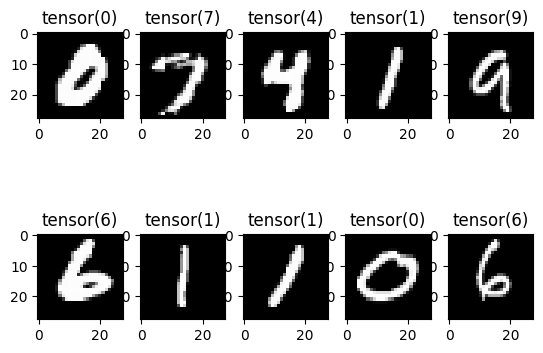

In [ ]:
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(torch.argmax(preds[i]))
  plt.imshow(torch.squeeze(test_feats[i]), cmap=plt.get_cmap('gray'))
plt.show()

Awesome! Looks like we're able to recognize handwritten digits pretty well. On to something more challenging...